Made to try to figure out how to line up dates even though they have different calendar types

Kind of a hacky approach for now, but I think it is OK?

**Known issues**:
- Duplicate Dates
   * CESM2 has duplicate dates (for now, just skipping this model)
   * SSP245 and SSP585 have tons of duplicate dates
- Can't decode times for CanESM5
- Takes a really long time to run - not sure why
- Not everything is showing up when I plot it - maybe didn't merge into xarray dataset super well??

**Questions:**
- How is dask embedded in here somehow??

### Set up Workspace

In [1]:
%matplotlib inline

import xarray as xr
import intake
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cftime
import xesmf as xe

# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
import util 
output_path='/home/jovyan/cmip6-outreach-tool/output/'

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['stac-catalog', 'stac-collection', 'stac-item'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [17]:
######### Define Settings for Data Dictionary
this_experiment_id = ['historical','ssp126', 'ssp370','ssp245','ssp585']
this_variable_id = 'tas'
this_table_id = 'Amon'
this_grid_label='gn'


######### Create Data Dictionary
import CreateDataDict
[dataset_info, dset_dict, modelnames]=CreateDataDict.createDataDict(this_experiment_id, this_variable_id, this_table_id, this_grid_label)

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 60 group(s)


### Create Functions for Regridding

In [6]:
### Create ds_out reference file
def CreateReferenceGrid(modelname, experiment_id,activity_id):
    dataset_info_subset = dataset_info[dataset_info['source_id']==modelname]
    institution_id = list(set(dataset_info_subset['institution_id']))[0]
    nametag=activity_id+'.'+institution_id+'.'+modelname+'.'+experiment_id+'.'+this_table_id+'.'+this_grid_label
    thisdata=dset_dict[nametag]
    ds_out = xr.Dataset({'lat': thisdata['lat'],
                         'lon': thisdata['lon']})
    return ds_out

def RegridModel(thisdata,latvariable='lat',lonvariable='lon'):
    ds_in = xr.Dataset({'lat': thisdata[latvariable],
                    'lon': thisdata[lonvariable],
                    'time': thisdata['time'],
                    this_variable_id: thisdata[this_variable_id]})
    regridder = xe.Regridder(ds_in, ds_out, 'nearest_s2d')
    thisdata_regridded = regridder(ds_in)
    thisdata_regridded.attrs.update(thisdata.attrs)
    return thisdata_regridded

### Create Xarray dataset of time series for all models

In [29]:
def reindex_time(startingtimes):
    newtimes = startingtimes.values
    for i in range(0,len(startingtimes)):
        yr = int(str(startingtimes.values[i])[0:4])
        mon = int(str(startingtimes.values[i])[5:7])
        day = int(str(startingtimes.values[i])[8:10])
        hr = int(str(startingtimes.values[i])[11:13])
        newdate = cftime.DatetimeProlepticGregorian(yr,mon,15)
        newtimes[i]=newdate
    return newtimes

def initializeDataSet(activity_id,experiment_id,modelname):
    dataset_info_subset = dataset_info[dataset_info['source_id']==modelname]
    institution_id = list(set(dataset_info_subset['institution_id']))[0]
    nametag=activity_id+'.'+institution_id+'.'+modelname+'.'+experiment_id+'.'+this_table_id+'.'+this_grid_label
    thisdata=dset_dict[nametag]
    thisdata=xr.decode_cf(thisdata)
    thisdata = thisdata.mean(dim=['member_id'])
    ###### Reformat dates to be Proleptic Gregorian date type
    newtimes = reindex_time(startingtimes = thisdata['time'])
    thistime = xr.DataArray(newtimes, coords=[newtimes], dims=['time'])
    thisdata['time'] = thistime
    ###### Regrid 
    
    #########################################
    thisval=thisdata[this_variable_id] #.mean(dim=['lat','lon'])
    ds = xr.Dataset({modelname: thisval},\
                    coords={'time': thistime})
                            #'modelnames': modelnameInd, \
                            #'lat': thislat, \
                            #'lon': thislon, \
                
    return ds

def fillDataSet():
    modelnames_toplot = []
    for modelname in modelnames:
        source_id = modelname
        dataset_info_subset = dataset_info[dataset_info['source_id']==source_id]
        institution_id = list(set(dataset_info_subset['institution_id']))[0]
        nametag = activity_id+'.'+institution_id+'.'+source_id+'.'+experiment_id+'.'+this_table_id+'.'+this_grid_label
        if nametag in dset_dict:
            ###### Reformat dates to be Proleptic Gregorian date type
            if (modelname=='MCM-UA-1-0'):
                # ERROR Different names for lat and lon
                print('** Skipping '+modelname)
            elif (modelname=='CESM2')and(experiment_id=='historical'):
                #ValueError: cannot reindex or align along dimension 'time' because the index has duplicate values
                print('** Skipping '+modelname)
            elif ((modelname=='CanESM5')and(experiment_id=='ssp126')):
                #OutOfBoundsDatetime: Cannot decode times from a non-standard calendar, '365_day', using pandas.
                print('** Skipping '+modelname)
            elif ((modelname=='CESM2-WACCM')and(experiment_id=='ssp370')):
                #ValueError: cannot reindex or align along dimension 'time' because the index has duplicate values
                print('** Skipping '+modelname)
            elif (experiment_id=='ssp245'):
                #ValueError: cannot reindex or align along dimension 'time' because the index has duplicate values
                print('** Skipping '+modelname)
            
            else:
                print(nametag)
                modelnames_toplot.append(modelname)
                thisdata=dset_dict[nametag]
                thisdata=xr.decode_cf(thisdata)
                thisdata = thisdata.mean(dim=['member_id'])
                newtimes = reindex_time(startingtimes = thisdata['time'])
                thisdata['time'] = xr.DataArray(newtimes, coords=[newtimes], dims=['time'])
                ###### Regrid this
                thisdata=RegridModel(thisdata)
                thisval=thisdata[this_variable_id] #.mean(dim=['lat','lon'])
                ds[modelname]=thisval
    return ds,modelnames_toplot

In [38]:
dict_timeSeries = dict()

this_experiment_id=['historical','ssp126', 'ssp370']#'ssp245','ssp585'] #

for experiment_id in this_experiment_id:
    print('---------------'+experiment_id+'---------------')
    if experiment_id=='historical':
        activity_id='CMIP'
    else:
        activity_id='ScenarioMIP'

    # Create xarray dataset using one model         
    ds= initializeDataSet(activity_id,experiment_id,modelname='CAMS-CSM1-0')
    ds_out = CreateReferenceGrid(modelname='CAMS-CSM1-0', activity_id = 'CMIP', experiment_id='historical')

    # read data from all other models into xarray dataset
    [ds,modelnames_toplot] = fillDataSet()
    
    # Convert from K to C
    for modelname in modelnames_toplot:
        ds[modelname]=ds[modelname]-273.15

    #Add dataset to dictionary
    dict_timeSeries[experiment_id] = ds
    dict_timeSeries[experiment_id+'_modelnameToPlot'] = modelnames_toplot

---------------historical---------------
CMIP.CAMS.CAMS-CSM1-0.historical.Amon.gn
Overwrite existing file: nearest_s2d_160x320_160x320.nc 
 You can set reuse_weights=True to save computing time.
using dimensions ('lat', 'lon') from data variable tas as the horizontal dimensions for this dataset.
** Skipping MCM-UA-1-0
CMIP.MIROC.MIROC6.historical.Amon.gn
Overwrite existing file: nearest_s2d_128x256_160x320.nc 
 You can set reuse_weights=True to save computing time.
using dimensions ('lat', 'lon') from data variable tas as the horizontal dimensions for this dataset.
CMIP.MOHC.UKESM1-0-LL.historical.Amon.gn
Overwrite existing file: nearest_s2d_144x192_160x320.nc 
 You can set reuse_weights=True to save computing time.
using dimensions ('lat', 'lon') from data variable tas as the horizontal dimensions for this dataset.
CMIP.NCC.NorCPM1.historical.Amon.gn
Overwrite existing file: nearest_s2d_96x144_160x320.nc 
 You can set reuse_weights=True to save computing time.
using dimensions ('lat',

In [39]:
testdata=dset_dict['ScenarioMIP.MIROC.MIROC6.ssp585.Amon.gn']
thisdata=xr.decode_cf(testdata)

thisdata = thisdata.mean(dim=['member_id'])
newtimes = reindex_time(startingtimes = thisdata['time'])
thisdata['time'] = xr.DataArray(newtimes, coords=[newtimes], dims=['time'])
###### Regrid this
thisdata=RegridModel(thisdata)
thisval=thisdata[this_variable_id] #.mean(dim=['lat','lon'])
print(np.shape(thisdata['time'].values))
print(ds)

Overwrite existing file: nearest_s2d_128x256_160x320.nc 
 You can set reuse_weights=True to save computing time.
using dimensions ('lat', 'lon') from data variable tas as the horizontal dimensions for this dataset.
(1032,)
<xarray.Dataset>
Dimensions:        (lat: 160, lon: 320, time: 1020)
Coordinates:
  * time           (time) object 2015-01-15 00:00:00 ... 2099-12-15 00:00:00
  * lon            (lon) float64 0.0 1.125 2.25 3.375 ... 356.6 357.8 358.9
  * lat            (lat) float64 -89.14 -88.03 -86.91 ... 86.91 88.03 89.14
Data variables:
    CAMS-CSM1-0    (time, lat, lon) float64 dask.array<chunksize=(488, 160, 320), meta=np.ndarray>
    MIROC6         (time, lat, lon) float64 dask.array<chunksize=(1020, 160, 320), meta=np.ndarray>
    UKESM1-0-LL    (time, lat, lon) float64 dask.array<chunksize=(1020, 160, 320), meta=np.ndarray>
    MIROC-ES2L     (time, lat, lon) float64 dask.array<chunksize=(1020, 160, 320), meta=np.ndarray>
    BCC-CSM2-MR    (time, lat, lon) float64 dask.ar

In [40]:
# Get indices for specific lat and lon
def find_loc_inds(thislat,thislon):
    lats = dict_timeSeries['historical']['lat'].values
    lons = dict_timeSeries['historical']['lon'].values
    lat_ind = np.where(abs(lats-thislat) == np.amin(abs(lats-thislat)))[0][0]
    lon_ind = np.where(abs(lons-thislon) == np.amin(abs(lons-thislon)))[0][0]
    return lat_ind, lon_ind
lat_ind, lon_ind = find_loc_inds(thislat = 47.6062,thislon = 237.67)

#warm point: (thislat = 4,thislon = 140) #

### Plot Time Series

In [ ]:
normalizeHistorical = True

fig = plt.figure(figsize=(10,6))
lstyle = ['-',':','--','-.','-']
fname='Historical-and-ScenarioTimeSeries'
for i in range(0,2):#len(this_experiment_id)):
    experiment_id = this_experiment_id[i]
    # Read in data for experiment id
    print('---------------'+experiment_id+'---------------')
    modelnames_toplot = dict_timeSeries[experiment_id+'_modelnameToPlot']
    ds = dict_timeSeries[experiment_id]
    
    # Calculate annual mean
    ds_annual=ds.groupby('time.year').mean('time')
    ds_annual=ds_annual.isel(lat=lat_ind,lon=lon_ind)
    
    if normalizeHistorical:
        # Normalize to historical
        if experiment_id=='historical':
            baseClim = ds_annual.isel(year=range(0,50)).mean(dim='year')
        ds_annual=ds_annual-baseClim
        fname=fname+'_normalized'
    
    for modelname in modelnames_toplot:
        print(modelname)
        plt.plot(ds_annual['year'],ds_annual[modelname],label=modelname,linestyle=lstyle[i])
plt.legend()
plt.xlabel('Year')
plt.xlim([1850,2200])
plt.ylabel('Temperature')
fig.savefig(output_path +fname+'.png', bbox_inches='tight') 

---------------historical---------------
CAMS-CSM1-0


### Troubleshoot w/maps

In [80]:
def quick_map(mapdata,lat,lon,plotPoints=False,YpointsToPlot=None,XpointsToPlot=None,title=None,cb_ttl=None,cmap=None,clim=None,filepath=None,sighatch=False,p=None,sigmask=None,markerstyle='x',markersize=1.0,norm=None):
    
    fig = plt.figure(figsize=(12,9))
    
    ax = plt.axes(projection=ccrs.Robinson())
    ax.coastlines(resolution='110m') #learn how to add resolution here??
    ax.set_global()

    cyclic_data, cyclic_lons = add_cyclic_point(mapdata,coord=lon)

    #cs = plt.contourf(cyclic_lons,lat,cyclic_data,60,transform=ccrs.PlateCarree(),extend='both')#,vmin=clim[0],vmax=clim[1])
    if norm:
        cs = plt.pcolormesh(cyclic_lons,lat,cyclic_data,transform=ccrs.PlateCarree())
    else:
        cs = plt.pcolormesh(cyclic_lons,lat,cyclic_data,transform=ccrs.PlateCarree(),norm=norm)
    

    # Choose your colormap
    if cmap:
        plt.set_cmap(cmap)
    else:
        plt.set_cmap(plt.cm.viridis)
        
    if sighatch:
        cyclic_sig, cyclic_lons = add_cyclic_point(sigmask,coord=lon)

        CLN, CLT = np.meshgrid(cyclic_lons,lat)

        # only put the hatches where the sigmask is >0.5
        #cyclic_sig = np.ma.masked_where(cyclic_sig<p,cyclic_sig)
        lat_sig = np.ma.masked_where(cyclic_sig<p,CLT)
        lat_sig = np.ma.masked_where(np.isnan(cyclic_sig),lat_sig)
        lon_sig = np.ma.masked_where(cyclic_sig<p,CLN)
        lon_sig = np.ma.masked_where(np.isnan(cyclic_sig),lon_sig)
        #hatch = plt.pcolor(cyclic_lons,lat,cyclic_sig,hatch='xxx',alpha=1.0,transform=ccrs.PlateCarree()); 

        hatch = ax.scatter(lon_sig,lat_sig,marker=markerstyle,s=markersize,c=[0.6, 0.6, 0.6],alpha=1.0,transform=ccrs.PlateCarree())
        
    if plotPoints:
        hatch = ax.scatter(XpointsToPlot,YpointsToPlot,marker=markerstyle,s=markersize,c=[0.6, 0.6, 0.6],alpha=1.0,transform=ccrs.PlateCarree())

    ax.patch.set_alpha(1.0)
   
    
    if title:
        plt.title(title,fontsize=16,y=1.05,loc='left')
        
    if clim:
        plt.clim(clim)  
        cs.set_clim(clim[0],clim[1])
        cs.set_clim(clim)
        
    cbar = plt.colorbar(ax=ax,orientation='horizontal',extend='both',pad=.02, shrink=0.9,norm=norm)
    cbar.ax.tick_params(labelsize=14) 
    
    if clim:
        cbar.set_clim(clim)

    if cb_ttl:
        cbar.set_label(cb_ttl,fontsize=14)
        
    plt.show()
    
    if filepath:
        fig.savefig(filepath+'.png',dpi=300,facecolor=None,edgecolor=None,bbox_inches='tight',transparent=True,pad_inches=0.2,linewidth=2)

        print('done saving file')

    plt.close()
    
    return fig,ax,cs,cbar

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.


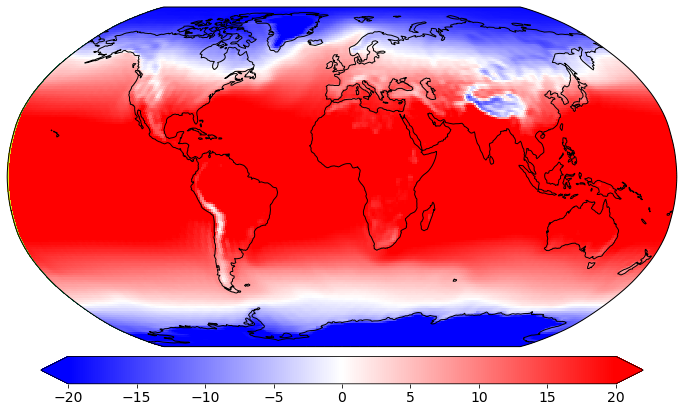

(<Figure size 864x648 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7feaede2e358>)

In [91]:
# nice maps:
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
thisdata=dset_dict[nametag]
mapdata=thisdata['tas'].mean(dim=['time','member_id'])

quick_map(mapdata-273.15,thisdata['lat'],thisdata['lon'],clim=[-20,20],cmap=plt.cm.bwr)